## iris데이터 회귀분석

독립변수(Input)는 petal_length 컬럼, 종속변수(Output)는 petal_width 컬럼으로 해보자.

* (1) DataFrame 생성

* (2) 회귀선 그래프

* (3) Spark를 사용하여 회귀분석하고 계수 출력

* (4) 실제와 예측 출력

* (5) 정확성 평가하고 출력

### 문제1. DataFrame 생성

In [1]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length","petal_width","species"])

In [2]:
iris.head() 

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
# isnull() 함수: 결측 값이 있는지 확인
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

### 문제2. 회귀선 그래프

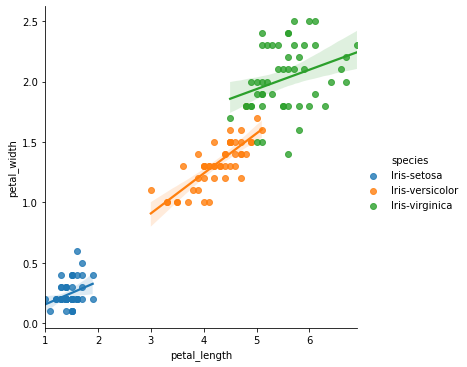

In [5]:
# 회귀선 그래프(종에 따라 그린 회귀선 그래프)
import seaborn as sns

sns.lmplot(x="petal_length", y="petal_width", data=iris, hue='species')

### 문제3. Spark를 사용하여 회귀분석하고 계수 출력

In [6]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

In [7]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [8]:
# 데이터프레임
irisDf = spark.createDataFrame(iris)

In [9]:
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [10]:
# 훈련, 테스트 데이터 분리
trainDf, testDf = irisDf.randomSplit([0.6, 0.4])

In [11]:
trainDf.count()

99

In [12]:
# species: string -> stringIndexer 사용해서 double 타입으로 만들기 -> onehotencoder로 vector로 변환
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="species", outputCol="speciesIndex")

#siModel = stringIndexer.fit(trainDf)
#siDf = siModel.transform(trainDf)
#siDf.printSchema()

In [13]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="speciesIndex", outputCol="speciesVec")

#enModel = encoder.fit(siDf)
#enDf = enModel.transform(siDf)
#enDf.printSchema()

In [14]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols = ["sepal_length", "sepal_width", "petal_length", "speciesVec"],
                                   outputCol = "features")

#vaDf = va.transform(enDf)
#vaDf.printSchema()

In [15]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features' , labelCol='petal_width', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [16]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [17]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)
#modelTrainDf.printSchema()

In [18]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.0,0.0,0.18096196193695513,0.16209672311915657,-0.2029220752113725]
Intercept: 0.555


### 문제4. 실제와 예측 출력

In [19]:
modelTestDf=model.transform(testDf)

In [20]:
modelTestDf.select('petal_width','prediction').show(10)

+-----------+------------------+
|petal_width|        prediction|
+-----------+------------------+
|        0.2|   0.6057981555698|
|        0.2|0.5877019593761045|
|        0.2|0.5877019593761045|
|        0.3|0.5877019593761045|
|        0.3|   0.6057981555698|
|        0.1|   0.6057981555698|
|        0.3|   0.6057981555698|
|        0.2| 0.641990547957191|
|        0.2| 0.641990547957191|
|        0.1|0.6238943517634955|
+-----------+------------------+
only showing top 10 rows



### 문제5. 정확성 평가하고 출력

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")

In [22]:
rmse=evaluator.evaluate(modelTestDf)

In [23]:
rmse

0.32597043990226804

In [24]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.326'